In [13]:
import os
import PIL
import torch
import random 
import zipfile
import numpy as np
from torch import nn
from PIL import Image
from glob import glob
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")
print(torch.__version__)

device: cpu
2.1.2+cpu


In [2]:
def unzip(zip_path, image_path):
    """unzips

    Args:
        zip_path (_type_): _description_
        image_path (_type_): _description_
    """
    if image_path.is_dir():
        print(f"{image_path} already exists")
    else:
        image_path.mkdir(parents=True, exist_ok=True)      
        
    if len(os.listdir(image_path)) > 0:
        print("Images already in folder") 
        pass
    else:
        with zipfile.ZipFile(zip_path, 'r') as zip_train:
            print('Unzipping Data')
            zip_train.extractall(image_path)    

In [3]:
zip_data_path = Path('zip_data/')
image_data_path = Path('image_data/')

train_zip_path = zip_data_path / 'DIV2K_train_HR.zip'
train_image_path = image_data_path / "train_images"

valid_zip_path = zip_data_path / 'DIV2K_valid_HR.zip'
valid_image_path = image_data_path / "valid_images"

unzip(train_zip_path, train_image_path)
unzip(valid_zip_path, valid_image_path)

image_data\train_images already exists
Images already in folder
image_data\valid_images already exists
Images already in folder


In [4]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(train_image_path)

There are 1 directories and 0 images in image_data\train_images
There are 0 directories and 800 images in image_data\train_images\DIV2K_train_HR


Image type is <class 'PIL.PngImagePlugin.PngImageFile'>
Image size is (1368, 2040)


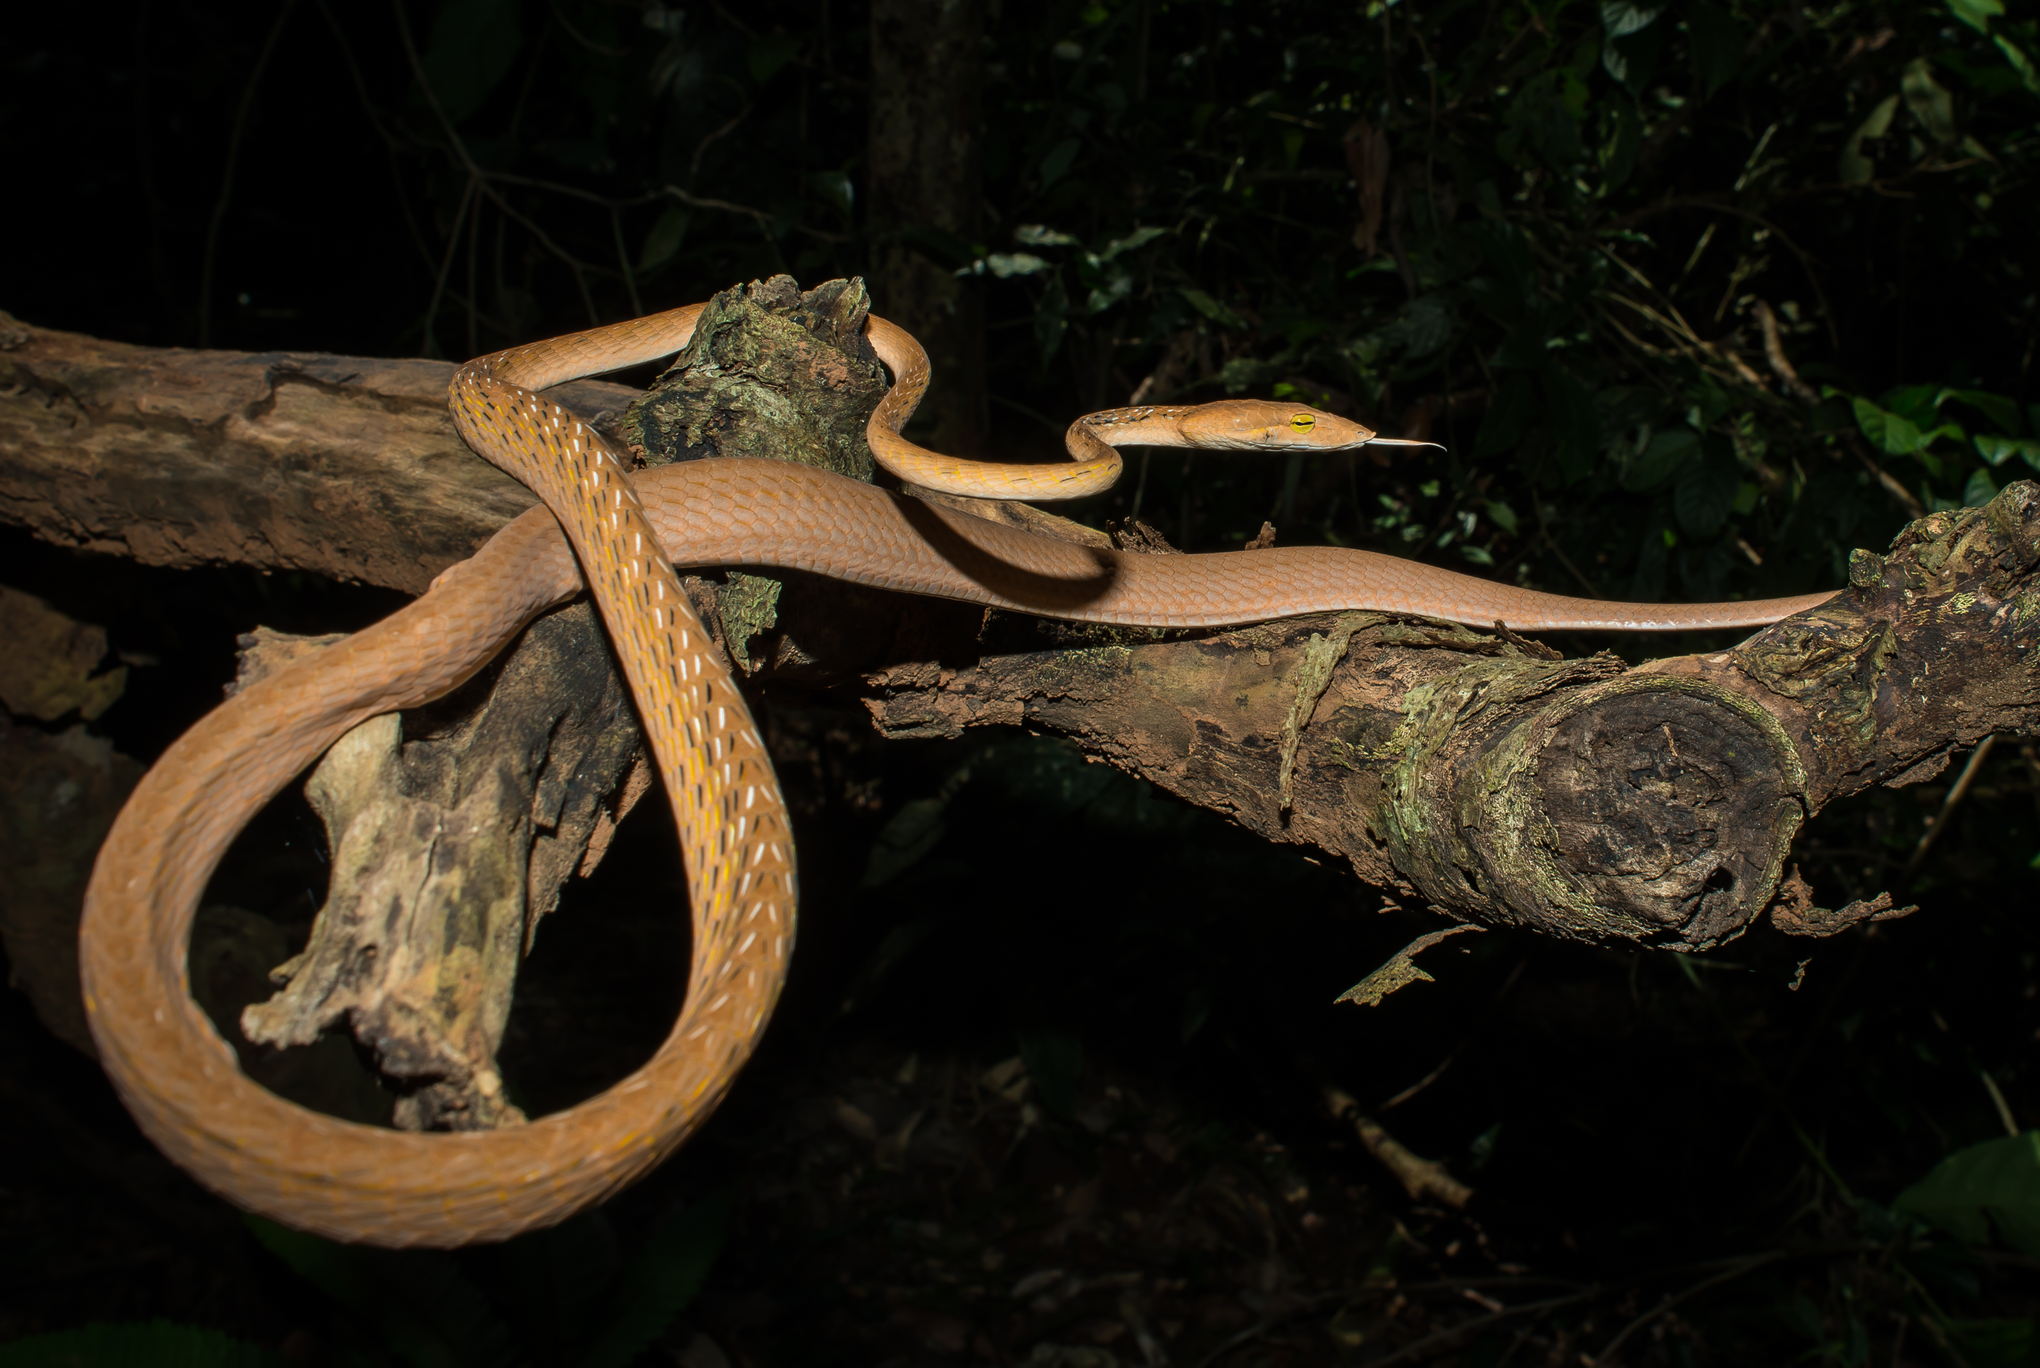

In [70]:
image_path_list = list(train_image_path.glob("*/*.png"))
random_img = random.choice(image_path_list)

im = Image.open(random_img)
im_height = im.height
im_width = im.width
print(f"Image type is {type(im)}")
print(f"Image size is {im_height, im_width}")
im

In [62]:
from torchvision.transforms import v2, InterpolationMode
import matplotlib.pyplot as plt

n = 2

img_transform = v2.Compose([
    v2.Resize(size=(int(im_height/n), int(im_width/n)), interpolation=InterpolationMode.BICUBIC),
    v2.RandomRotation(degrees=90),
    v2.RandomPerspective(distortion_scale=0.5, p = 0.33),
    v2.PILToTensor()
    # v2.Lambda(lambda crops: torch.stack([v2.PILToTensor()(crop) for crop in crops]))
])

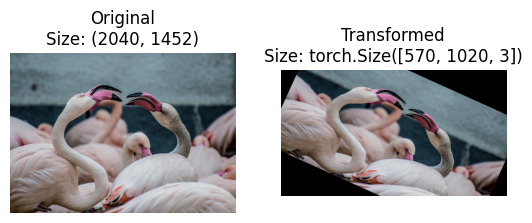

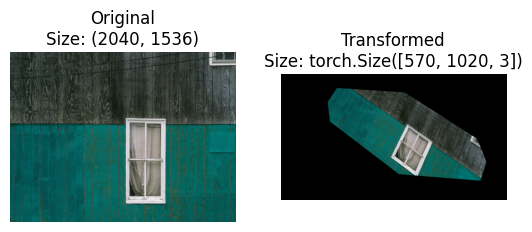

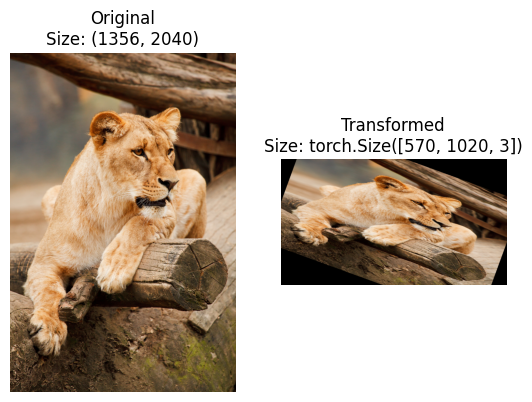

In [69]:
def plot_transformation(path_list, transform, n=3):
    """
    input:
        path_list: list of paths
        transform: a transform function
        n: the number of images to display
    output:
        displays random images in pairs of the original and transformed image
    """
    random_paths = random.sample(path_list, n)
    for path in random_paths:
        with Image.open(path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # OG image
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            # Transformed image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)
            
            # fig.suptitle(f"Before and After Transformation", fontsize=16)
            
plot_transformation(image_path_list,
                    img_transform,
                    3)

In [85]:
from torch.utils.data import Dataset
from typing import Tuple
import pathlib

class CustomDIV2K(Dataset):
    
    def __init__(self, targ_dir:str, transforms=None):
        # get images from a path
        self.paths = list(pathlib.Path(targ_dir).glob(f"*/*.png"))
        # do transforms if necessary
        self.transform = transforms
        
    def load_image(self, idx:int) -> Image.Image:
        image_path = self.paths[idx]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the LR and HR images given an index

        Args:
            idx (int): Index of image

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: returns images in forms of tensors
        """
        img = self.load_image(idx)
        HR = img
        LR = self.transform(img).permute(1,2,0)
        
        return HR, LR

In [86]:
train_data_custom = CustomDIV2K(train_image_path,
            img_transform)

valid_data_custom = CustomDIV2K(valid_image_path,
            img_transform)

print(f"Length of training data: {len(train_data_custom)}")
print(f"Length of Validation data: {len(valid_data_custom)}")

Length of training data: 800
Length of Validation data: 100


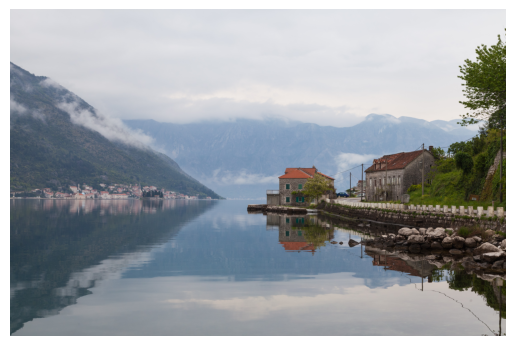

In [89]:
plt.imshow(train_data_custom.__getitem__(3)[0])
plt.axis(False);